In [27]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm, BoundaryNorm, LinearSegmentedColormap
import matplotlib.dates as mdates
import numpy as np
import os
import pandas as pd
from pyproj import Transformer
import string
import xarray as xr

import warnings
warnings.filterwarnings('ignore')

In [28]:
### Load data
dsn_hv = xr.open_zarr('/pl/active/WRFLES_GAD/wfp_3dpbl/real/3dpbl/nwf/2020_08/final.zarr')
dsv_hv = xr.open_zarr('/pl/active/WRFLES_GAD/wfp_3dpbl/real/3dpbl/vw-only/2020_08/final.zarr')
dsf_hv = xr.open_zarr('/pl/active/WRFLES_GAD/wfp_3dpbl/real/3dpbl/lease/2020_08/final.zarr')

dsn_m = xr.open_zarr('/pl/active/WRFLES_GAD/wfp_3dpbl/real/mynn-wrf4.3/nwf/2020_08/final.zarr')
dsv_m = xr.open_zarr('/pl/active/WRFLES_GAD/wfp_3dpbl/real/mynn-wrf4.3/vw-only/2020_08/final.zarr')
dsf_m = xr.open_zarr('/pl/active/WRFLES_GAD/wfp_3dpbl/real/mynn-wrf4.3/lease/2020_08/final.zarr')

In [29]:
### Grab basic data about files
## Times
times_n_hv = dsn_hv['time'].values
times_v_hv = dsv_hv['time'].values
times_f_hv = dsf_hv['time'].values

times_n_m = dsn_m['time'].values
times_v_m = dsv_m['time'].values
times_f_m = dsf_m['time'].values

## Coords
lons = dsn_hv['lon'].values
lats = dsn_hv['lat'].values
mean_lon = lons.mean()
mean_lat = lats.mean()

## Heights
heights = dsn_hv['height'].values

In [30]:
### Replace Time iterator data with timestamps
dsn_m = dsn_m.assign_coords({'Time':dsn_m['time'].data})
dsv_m = dsv_m.assign_coords({'Time':dsv_m['time'].data})
dsf_m = dsf_m.assign_coords({'Time':dsf_m['time'].data})
dsn_hv = dsn_hv.assign_coords({'Time':dsn_hv['time'].data})
dsv_hv = dsv_hv.assign_coords({'Time':dsv_hv['time'].data})
dsf_hv = dsf_hv.assign_coords({'Time':dsf_hv['time'].data})

In [31]:
### Calculate common time index for Aug 2020
## Prepare start and end index to trim timestamps to only Aug 2020
start_time = np.datetime64('2020-08-01')
end_time = np.datetime64('2020-09-01')

trimtime_n_hv_start = np.where(times_n_hv==start_time)[0][0]
trimtime_n_hv_end = np.where(times_n_hv==end_time)[0][0]
trimtime_v_hv_start = np.where(times_v_hv==start_time)[0][0]
trimtime_v_hv_end = np.where(times_v_hv==end_time)[0][0]
trimtime_f_hv_start = np.where(times_f_hv==start_time)[0][0]
trimtime_f_hv_end = np.where(times_f_hv==end_time)[0][0]

trimtime_n_m_start = np.where(times_n_m==start_time)[0][0]
trimtime_n_m_end = np.where(times_n_m==end_time)[0][0]
trimtime_v_m_start = np.where(times_v_m==start_time)[0][0]
trimtime_v_m_end = np.where(times_v_m==end_time)[0][0]
trimtime_f_m_start = np.where(times_f_m==start_time)[0][0]
trimtime_f_m_end = np.where(times_f_m==end_time)[0][0]

times = times_n_hv[trimtime_n_hv_start:trimtime_n_hv_end]

In [32]:
### Read turbine data
turbine_file_vw = 'windturbines_vw.txt'
turbine_df_vw = pd.read_csv(turbine_file_vw, delim_whitespace=True, usecols=[0,1], names=['Lat', 'Long'])
n_turb_vw = len(turbine_df_vw)

turbine_file_full = 'windturbines_full.txt'
turbine_df_full = pd.read_csv(turbine_file_full, delim_whitespace=True, usecols=[0,1], names=['Lat', 'Long'])
n_turb_full = len(turbine_df_full)

In [33]:
### Read idealized turbine data
turbine_file = '/projects/olry2348/WFIP2-WRF-3DPBL/runs/idealized/neutral/mynn-ztke/windturbines-ij.txt'
turbine_df = pd.read_csv(turbine_file, delim_whitespace=True, usecols=[0,1], names=['i', 'j'])

turbine_properties = '/projects/olry2348/WFIP2-WRF-3DPBL/runs/idealized/neutral/mynn-ztke/wind-turbine-1.tbl'
f = open(turbine_properties, "r")
lines = f.readlines()
hubheight = np.float(lines[1].split()[0])
rotor_diameter = np.float(lines[1].split()[1])
rotor_top = hubheight + rotor_diameter/2
rotor_bot = hubheight - rotor_diameter/2

print("Hub height", hubheight)
print("Rotor diameter", rotor_diameter)

Hub height 138.0
Rotor diameter 215.0


In [34]:
cols = ['Wspd', 'Thrust', 'Power']
property_df = np.zeros((len(lines[2:]), 3))
for i in range(len(property_df)):
    line = lines[2+i]
    property_df[i,0] = np.float(line.split()[0])
    property_df[i,1] = np.float(line.split()[1])
    property_df[i,2] = np.float(line.split()[2])
property_df = pd.DataFrame(property_df, columns=cols)
property_df = property_df.set_index('Wspd')

In [35]:
### Pull key parameters out of turbine files
turb_lat_min_vw = turbine_df_vw['Lat'].min()
turb_lat_max_vw = turbine_df_vw['Lat'].max()
turb_long_min_vw = turbine_df_vw['Long'].min()
turb_long_max_vw = turbine_df_vw['Long'].max()

turb_lat_min_full = turbine_df_full['Lat'].min()
turb_lat_max_full = turbine_df_full['Lat'].max()
turb_long_min_full = turbine_df_full['Long'].min()
turb_long_max_full = turbine_df_full['Long'].max()

MAP_BOUNDS_turb_vw = [turb_long_min_vw-1, turb_long_max_vw+1, turb_lat_min_vw-1, turb_lat_max_vw+0.5]
MAP_BOUNDS_turb_vw_zoom = [turb_long_min_vw-0.1, turb_long_max_vw+0.1, turb_lat_min_vw-0.1, turb_lat_max_vw+0.1]
MAP_BOUNDS_turb_full = [turb_long_min_full-0.5, turb_long_max_full+0.5, turb_lat_min_full-0.3, turb_lat_max_full+0.5]

In [36]:
### Identify ij of grid cells within VW
## Open copied list of turbine data from rsl.out.0000
with open('wind-turbine-locs.txt') as f:
    lines = f.readlines()
    
## Grab turbine number, west_east number, and south_north number
turb_list_ij_vw = []
for i in range(len(lines)):
    if i%2==0: continue   # Skip every other line
    turb_num = int(lines[i][52:55].strip())   # We include this for some testing, but ultimately drop
    west_east_num = int(lines[i][120:123])-1  # Subtract 1 because Python indexing
    south_north_num = int(lines[i][134:137])-1
    turb_list_ij_vw.append([turb_num, west_east_num, south_north_num])
    
## Format into dataframe
turb_df_ij_vw = pd.DataFrame(np.array(turb_list_ij_vw), columns=['Num', 'west_east_num', 'south_north_num'])

## Count the number of turbines in each cell
turb_cell_count = turb_df_ij_vw.groupby(["west_east_num", "south_north_num"]).size().reset_index(name="Count").copy()

## Drop duplicates
turb_df_ij_vw = turb_df_ij_vw.drop(labels='Num', axis=1)
turb_df_ij_vw = turb_df_ij_vw.drop_duplicates()

## Add info on turbines per cell
turb_df_ij_vw['TurbPerCell'] = 0
for i in range(len(turb_df_ij_vw)):
    unique_i = turb_df_ij_vw['west_east_num'].iloc[i]
    unique_j = turb_df_ij_vw['south_north_num'].iloc[i]
    unique_ind = turb_df_ij_vw[(turb_df_ij_vw['west_east_num']==unique_i) \
                               & (turb_df_ij_vw['south_north_num']==unique_j)].index[0]

    turb_per_cell = turb_cell_count[(turb_cell_count['west_east_num']==unique_i) \
                   & (turb_cell_count['south_north_num']==unique_j)]['Count'].values[0]
    
    turb_df_ij_vw.loc[unique_ind, 'TurbPerCell'] = turb_per_cell
    
## Cleanup
turb_df_ij_vw = turb_df_ij_vw.reset_index()
turb_df_ij_vw = turb_df_ij_vw.drop(columns=['index'])

In [37]:
### Create a mask for the Vineyard Wind cells
## Create mask
vwmask = np.zeros_like(dsn_m['lat'].values)
for i in range(len(turb_df_ij_vw)):
    iloc = turb_df_ij_vw.loc[i, 'west_east_num']
    jloc = turb_df_ij_vw.loc[i, 'south_north_num']
    nturb = turb_df_ij_vw.loc[i, 'TurbPerCell']
    vwmask[jloc, iloc] = nturb
    
## Store in datasets
dsn_m['VWMask'] = (('south_north', 'west_east'), vwmask)
dsn_hv['VWMask'] = (('south_north', 'west_east'), vwmask)
dsv_m['VWMask'] = (('south_north', 'west_east'), vwmask)
dsv_hv['VWMask'] = (('south_north', 'west_east'), vwmask)
dsf_m['VWMask'] = (('south_north', 'west_east'), vwmask)
dsf_hv['VWMask'] = (('south_north', 'west_east'), vwmask)

In [38]:
# ### Visualize mask
# proj = ccrs.PlateCarree()
# fig, ax = plt.subplots(1, 1, figsize=(4, 4), subplot_kw=dict(projection=proj), dpi=150)
# ax.set_extent(MAP_BOUNDS_turb_vw_zoom)

# im1 = ax.pcolormesh(lons,
#              lats,
#              dsn_m['VWMask'],
#              transform=ccrs.PlateCarree())

# fig.colorbar(im1, ax=ax)

# plt.show()

In [39]:
### Prepare map elements
coastline_50m = cfeature.NaturalEarthFeature('physical', 'coastline', '50m')
ocean_50m = cfeature.NaturalEarthFeature('physical', 'ocean', '50m')
land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m')

states_50m = cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces_lakes', '50m')

In [40]:
### Process shapefiles for lease areas
## Load shapefiles
# df_lease = gpd.read_file('/home/orybchuk/shapefiles/BOEM_Lease_Areas_3_29_2021.shp')
df_lease = gpd.read_file('/projects/olry2348/shapefiles/BOEM_Lease_Areas_3_29_2021.shp')
crs = ccrs.PlateCarree()

## Merge (aka dissolve) geometries by lease area
df_lease_group = df_lease.dissolve(by='LeaseNo_Co')
df_lease_group = df_lease_group[~df_lease_group.index.str.contains('Virginia')]
df_lease_group = df_lease_group[~df_lease_group.index.str.contains('Avangrid Renewables')]
df_lease_group = df_lease_group[~df_lease_group.index.str.contains('Oregon')] 
df_lease_group = df_lease_group[~df_lease_group.index.str.contains('Narragansett')]

In [41]:
### Calculate centroids of all lease areas
## Calculate centroid in an equal area projection
lease_centroid_lat = df_lease_group.to_crs('+proj=cea').centroid.to_crs(df_lease_group.crs).y
lease_centroid_lon = df_lease_group.to_crs('+proj=cea').centroid.to_crs(df_lease_group.crs).x

df_lease_group['CentroidLat'] = lease_centroid_lat
df_lease_group['CentroidLon'] = lease_centroid_lon

## Calculate grid cell closest to centroid
lease_centroid_i = np.zeros_like(lease_centroid_lon)
lease_centroid_j = np.zeros_like(lease_centroid_lat)

for i in range(len(lease_centroid_lat)):
    centroid_dists = np.sqrt((lats - lease_centroid_lat[i])**2 \
                        + (lons - lease_centroid_lon[i])**2)

    this_j, this_i = np.unravel_index(np.argmin(centroid_dists, axis=None), centroid_dists.shape)
    
    lease_centroid_i[i], lease_centroid_j[i] = this_i, this_j
    
df_lease_group['CentroidI'] = lease_centroid_i.astype(int)
df_lease_group['CentroidJ'] = lease_centroid_j.astype(int)

# Look at aggregate power output across the entire farm

In [42]:
### Calculate average power output at VW by stability, using VW centroid for reference
## Identify VW centroid
vw_i = df_lease_group.loc['OCS-A 0501 - Vineyard Wind LLC', 'CentroidI']
vw_j = df_lease_group.loc['OCS-A 0501 - Vineyard Wind LLC', 'CentroidJ']

## Grab heat fluxes (for binning)
hfx_m = dsn_m['HFX'].isel(south_north=vw_j, west_east=vw_i, Time=slice(trimtime_n_m_start, trimtime_n_m_end))
hfx_hv = dsn_hv['HFX'].isel(south_north=vw_j, west_east=vw_i, Time=slice(trimtime_n_hv_start, trimtime_n_hv_end))

## Grab time indices by stability; use the NWF heat fluxes to identify times for all simulations
stable_thresh = -5   # W/m2
unstable_thresh = 5  # W/m2

# Grab timestamps
times_s_m = hfx_m[hfx_m < stable_thresh]['Time'].values
times_n_m = hfx_m[(hfx_m > stable_thresh) & (hfx_m < unstable_thresh)]['Time'].values
times_u_m = hfx_m[hfx_m > unstable_thresh]['Time'].values

times_s_hv = hfx_hv[hfx_hv < stable_thresh]['Time'].values
times_n_hv = hfx_hv[(hfx_hv > stable_thresh) & (hfx_hv < unstable_thresh)]['Time'].values
times_u_hv = hfx_hv[hfx_hv > unstable_thresh]['Time'].values

## Calculate power normalized by number of turbines in a cell + NaN'd where there are 0 turbines
dsv_m['NormPOWER'] = dsv_m['POWER'] / dsv_m['VWMask']
dsv_hv['NormPOWER'] = dsv_hv['POWER'] / dsv_hv['VWMask']

vw_filt_power_m = xr.where(dsf_m['VWMask']==0, # Pre-filter out cells that aren't VW
                        0, 
                        dsf_m['POWER'])
dsf_m['NormPOWER'] = vw_filt_power_m / dsf_m['VWMask']

vw_filt_power_hv = xr.where(dsf_hv['VWMask']==0, # Pre-filter out cells that aren't VW
                        0, 
                        dsf_hv['POWER'])
dsf_hv['NormPOWER'] = vw_filt_power_hv / dsf_hv['VWMask']

## Calculate average capacity factor by stability
dsv_m['CapFacStable'] = dsv_m['NormPOWER'].sel(Time=times_s_m).mean('Time').compute() / 1e6 / 12 * 100
dsv_m['CapFacNeutral'] = dsv_m['NormPOWER'].sel(Time=times_n_m).mean('Time').compute() / 1e6 / 12 * 100
dsv_m['CapFacUnstable'] = dsv_m['NormPOWER'].sel(Time=times_u_m).mean('Time').compute() / 1e6 / 12 * 100

dsf_m['CapFacStable'] = dsf_m['NormPOWER'].sel(Time=times_s_m).mean('Time').compute() / 1e6 / 12 * 100
dsf_m['CapFacNeutral'] = dsf_m['NormPOWER'].sel(Time=times_n_m).mean('Time').compute() / 1e6 / 12 * 100
dsf_m['CapFacUnstable'] = dsf_m['NormPOWER'].sel(Time=times_u_m).mean('Time').compute() / 1e6 / 12 * 100

dsv_hv['CapFacStable'] = dsv_hv['NormPOWER'].sel(Time=times_s_hv).mean('Time').compute() / 1e6 / 12 * 100
dsv_hv['CapFacNeutral'] = dsv_hv['NormPOWER'].sel(Time=times_n_hv).mean('Time').compute() / 1e6 / 12 * 100
dsv_hv['CapFacUnstable'] = dsv_hv['NormPOWER'].sel(Time=times_u_hv).mean('Time').compute() / 1e6 / 12 * 100

dsf_hv['CapFacStable'] = dsf_hv['NormPOWER'].sel(Time=times_s_hv).mean('Time').compute() / 1e6 / 12 * 100
dsf_hv['CapFacNeutral'] = dsf_hv['NormPOWER'].sel(Time=times_n_hv).mean('Time').compute() / 1e6 / 12 * 100
dsf_hv['CapFacUnstable'] = dsf_hv['NormPOWER'].sel(Time=times_u_hv).mean('Time').compute() / 1e6 / 12 * 100

In [43]:
# ## Calculate idealized NWF power production
# ##   Note: This approach works for the month-long arrays, but probably not the year-long ones
# # Initialize arrays
# dsn_m_power = np.zeros_like(dsn_m['HFX'])
# dsn_hv_power = np.zeros_like(dsn_hv['HFX'])
    
# # Iterate over grid cells in VW
# for i in range(len(turb_df_ij_vw)):
#     # Select grid cell
#     unique_i = turb_df_ij_vw['west_east_num'].iloc[i]
#     unique_j = turb_df_ij_vw['south_north_num'].iloc[i]

#     dsn_m_power[:,unique_j,unique_i] = np.interp(dsn_m['WSPD'].isel(south_north=unique_j,west_east=unique_i,bottom_top=6), 
#                                          property_df.index, 
#                                          property_df['Power'], 
#                                          left=0.0, right=0.0)
#     dsn_hv_power[:,unique_j,unique_i] = np.interp(dsn_hv['WSPD'].isel(south_north=unique_j,west_east=unique_i,bottom_top=6), 
#                                          property_df.index, 
#                                          property_df['Power'], 
#                                          left=0.0, right=0.0)
    
# # Save data
# dsn_m['POWER'] = (('Time', 'south_north', 'west_east'), dsn_m_power)
# dsn_m['POWER'].to_netcdf('/pl/active/WRFLES_GAD/wfp_3dpbl/real/3dpbl/nwf/2020_08/dsn_m_power.nc')

# dsn_hv['POWER'] = (('Time', 'south_north', 'west_east'), dsn_hv_power)
# dsn_hv['POWER'].to_netcdf('/pl/active/WRFLES_GAD/wfp_3dpbl/real/3dpbl/nwf/2020_08/dsn_hv_power.nc')

In [44]:
## Calculate idealized VW_ONLY and LEASE power production to see how good the NWF power approximation is
##   Note: This approach works for the month-long arrays, but probably not the year-long ones
# Initialize arrays
# dsv_m_power = np.zeros_like(dsv_m['HFX'])
# dsv_hv_power = np.zeros_like(dsv_hv['HFX'])
# dsf_m_power = np.zeros_like(dsf_m['HFX'])
# dsf_hv_power = np.zeros_like(dsf_hv['HFX'])

# # Iterate over grid cells in VW
# for i in range(len(turb_df_ij_vw)):
#     # Select grid cell
#     unique_i = turb_df_ij_vw['west_east_num'].iloc[i]
#     unique_j = turb_df_ij_vw['south_north_num'].iloc[i]

#     dsv_m_power[:,unique_j,unique_i] = np.interp(dsv_m['WSPD'].isel(south_north=unique_j,west_east=unique_i,bottom_top=6), 
#                                          property_df.index, 
#                                          property_df['Power'], 
#                                          left=0.0, right=0.0)
#     dsv_hv_power[:,unique_j,unique_i] = np.interp(dsv_hv['WSPD'].isel(south_north=unique_j,west_east=unique_i,bottom_top=6), 
#                                          property_df.index, 
#                                          property_df['Power'], 
#                                          left=0.0, right=0.0)
    
#     dsf_m_power[:,unique_j,unique_i] = np.interp(dsf_m['WSPD'].isel(south_north=unique_j,west_east=unique_i,bottom_top=6), 
#                                          property_df.index, 
#                                          property_df['Power'], 
#                                          left=0.0, right=0.0)
#     dsf_hv_power[:,unique_j,unique_i] = np.interp(dsf_hv['WSPD'].isel(south_north=unique_j,west_east=unique_i,bottom_top=6), 
#                                          property_df.index, 
#                                          property_df['Power'], 
#                                          left=0.0, right=0.0)
    
# Save data
# dsv_m['POWERapprox'] = (('Time', 'south_north', 'west_east'), dsv_m_power)
# dsv_m['POWERapprox'].to_netcdf('/pl/active/WRFLES_GAD/wfp_3dpbl/real/3dpbl/nwf/2020_08/dsv_m_power_approx.nc')

# dsv_hv['POWERapprox'] = (('Time', 'south_north', 'west_east'), dsv_hv_power)
# dsv_hv['POWERapprox'].to_netcdf('/pl/active/WRFLES_GAD/wfp_3dpbl/real/3dpbl/nwf/2020_08/dsv_hv_power_approx.nc')

# dsf_m['POWERapprox'] = (('Time', 'south_north', 'west_east'), dsf_m_power)
# dsf_m['POWERapprox'].to_netcdf('/pl/active/WRFLES_GAD/wfp_3dpbl/real/3dpbl/nwf/2020_08/dsf_m_power_approx.nc')

# dsf_hv['POWERapprox'] = (('Time', 'south_north', 'west_east'), dsf_hv_power)
# dsf_hv['POWERapprox'].to_netcdf('/pl/active/WRFLES_GAD/wfp_3dpbl/real/3dpbl/nwf/2020_08/dsf_hv_power_approx.nc')

In [45]:
### Calculate wake loss at VW
## Read in NWF power data
power_nwf_m = xr.open_dataset('/pl/active/WRFLES_GAD/wfp_3dpbl/real/3dpbl/nwf/2020_08/dsn_m_power.nc')
power_nwf_hv = xr.open_dataset('/pl/active/WRFLES_GAD/wfp_3dpbl/real/3dpbl/nwf/2020_08/dsn_hv_power.nc')

## Calculate time-resolved NWF capacity factor
capfac_nwf_m = power_nwf_m['POWER'] / 1e3 / 12 * 100
capfac_nwf_hv = power_nwf_hv['POWER'] / 1e3 / 12 * 100

## Filter out the non-zero producing cells to focus only on VW
capfac_nwf_m = capfac_nwf_m.where(dsn_m['VWMask']!=0.0)
capfac_nwf_hv = capfac_nwf_hv.where(dsn_hv['VWMask']!=0.0)

## Calculate average NWF capacity factor by stability
capfac_nwf_s_m = capfac_nwf_m.sel(Time=times_s_m).mean('Time').compute()
capfac_nwf_n_m = capfac_nwf_m.sel(Time=times_n_m).mean('Time').compute()
capfac_nwf_u_m = capfac_nwf_m.sel(Time=times_u_m).mean('Time').compute()

capfac_nwf_s_hv = capfac_nwf_hv.sel(Time=times_s_hv).mean('Time').compute()
capfac_nwf_n_hv = capfac_nwf_hv.sel(Time=times_n_hv).mean('Time').compute()
capfac_nwf_u_hv = capfac_nwf_hv.sel(Time=times_u_hv).mean('Time').compute()

## Calculate losses by stability
loss_s_m_v = dsv_m['CapFacStable'] - capfac_nwf_s_m
loss_n_m_v = dsv_m['CapFacNeutral'] - capfac_nwf_n_m
loss_u_m_v = dsv_m['CapFacUnstable'] - capfac_nwf_u_m

loss_s_m_f = dsf_m['CapFacStable'] - capfac_nwf_s_m
loss_n_m_f = dsf_m['CapFacNeutral'] - capfac_nwf_n_m
loss_u_m_f = dsf_m['CapFacUnstable'] - capfac_nwf_u_m

loss_s_hv_v = dsv_hv['CapFacStable'] - capfac_nwf_s_hv
loss_n_hv_v = dsv_hv['CapFacNeutral'] - capfac_nwf_n_hv
loss_u_hv_v = dsv_hv['CapFacUnstable'] - capfac_nwf_u_hv

loss_s_hv_f = dsf_hv['CapFacStable'] - capfac_nwf_s_hv
loss_n_hv_f = dsf_hv['CapFacNeutral'] - capfac_nwf_n_hv
loss_u_hv_f = dsf_hv['CapFacUnstable'] - capfac_nwf_u_hv

## Store internal wake calculation
dsv_m.attrs['IntWakeStable'] = np.nanmean(loss_s_m_v)
dsv_m.attrs['IntWakeNeutral'] = np.nanmean(loss_n_m_v)
dsv_m.attrs['IntWakeUnstable'] = np.nanmean(loss_u_m_v)

dsf_m.attrs['IntWakeStable'] = np.nanmean(loss_s_m_f)
dsf_m.attrs['IntWakeNeutral'] = np.nanmean(loss_n_m_f)
dsf_m.attrs['IntWakeUnstable'] = np.nanmean(loss_u_m_f)

dsv_hv.attrs['IntWakeStable'] = np.nanmean(loss_s_hv_v)
dsv_hv.attrs['IntWakeNeutral'] = np.nanmean(loss_n_hv_v)
dsv_hv.attrs['IntWakeUnstable'] = np.nanmean(loss_u_hv_v)

dsf_hv.attrs['IntWakeStable'] = np.nanmean(loss_s_hv_f)
dsf_hv.attrs['IntWakeNeutral'] = np.nanmean(loss_n_hv_f)
dsf_hv.attrs['IntWakeUnstable'] = np.nanmean(loss_u_hv_f)

In [46]:
### Create custom colorbars
def calc_viridis_colorbar(cm_min, cm_max, cm_interval):
    '''
    Calculate tick bounds, a discrete colormap, and a norm for use with pcolormesh plots
    '''
    custom_bounds = np.arange(cm_min, cm_max+cm_interval, cm_interval) 

    all_colors = plt.cm.viridis(np.linspace(0, 1, int((cm_max-cm_min)/cm_interval)))

    custom_cmap = LinearSegmentedColormap.from_list('custom_map',
        all_colors)
    custom_cmap.set_over('magenta')
    custom_cmap.set_under('magenta')
    custom_cmap.set_bad('lightgray')

    custom_norm = BoundaryNorm(custom_bounds, custom_cmap.N)
    
    return custom_bounds, custom_cmap, custom_norm

def calc_cividis_colorbar(cm_min, cm_max, cm_interval):
    '''
    Calculate tick bounds, a discrete colormap, and a norm for use with pcolormesh plots
    '''
    custom_bounds = np.arange(cm_min, cm_max+cm_interval, cm_interval) 

    all_colors = plt.cm.cividis(np.linspace(0, 1, int((cm_max-cm_min)/cm_interval)))

    custom_cmap = LinearSegmentedColormap.from_list('custom_map',
        all_colors)
    custom_cmap.set_over('magenta')
    custom_cmap.set_under('magenta')
    custom_cmap.set_bad('lightgray')

    custom_norm = BoundaryNorm(custom_bounds, custom_cmap.N)
    
    return custom_bounds, custom_cmap, custom_norm

def calc_magma_colorbar(cm_min, cm_max, cm_interval):
    '''
    Calculate tick bounds, a discrete colormap, and a norm for use with pcolormesh plots
    '''
    custom_bounds = np.arange(cm_min, cm_max+cm_interval, cm_interval) 

    all_colors = plt.cm.magma(np.linspace(0, 1, int((cm_max-cm_min)/cm_interval)))

    custom_cmap = LinearSegmentedColormap.from_list('custom_map',
        all_colors)
    custom_cmap.set_over('magenta')
    custom_cmap.set_under('magenta')
    custom_cmap.set_bad('lightgray')

    custom_norm = BoundaryNorm(custom_bounds, custom_cmap.N)
    
    return custom_bounds, custom_cmap, custom_norm

def calc_plasma_colorbar(cm_min, cm_max, cm_interval):
    '''
    Calculate tick bounds, a discrete colormap, and a norm for use with pcolormesh plots
    '''
    custom_bounds = np.arange(cm_min, cm_max+cm_interval, cm_interval) 

    all_colors = plt.cm.plasma(np.linspace(0, 1, int((cm_max-cm_min)/cm_interval)))

    custom_cmap = LinearSegmentedColormap.from_list('custom_map',
        all_colors)
    custom_cmap.set_over('magenta')
    custom_cmap.set_under('magenta')
    custom_cmap.set_bad('lightgray')

    custom_norm = BoundaryNorm(custom_bounds, custom_cmap.N)
    
    return custom_bounds, custom_cmap, custom_norm

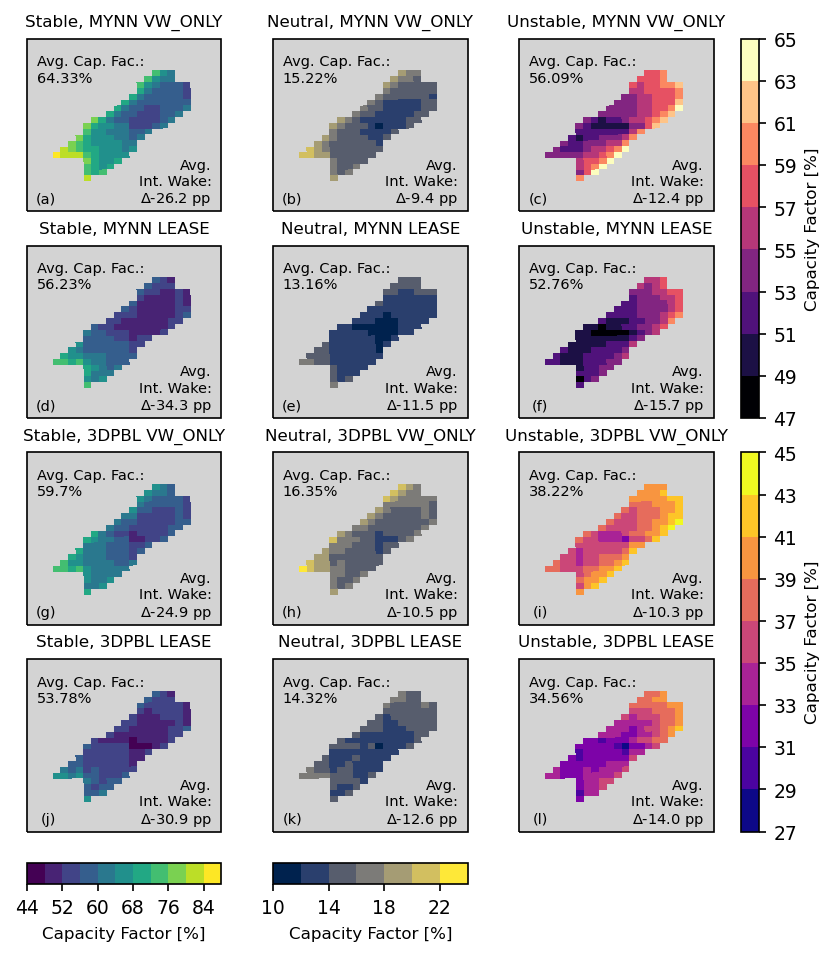

In [47]:
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(4, 3, figsize=(6, 7), subplot_kw=dict(projection=proj),
                          sharex=True, sharey=True, dpi=150)
ax[0,0].set_extent(MAP_BOUNDS_turb_vw_zoom)


cm_min1 = 44
cm_max1 = 88
cm_interval1 = 4
cm_min2 = 10
cm_max2 = 24
cm_interval2 = 2
cm_min3 = 47
cm_max3 = 65
cm_interval3 = 2
cm_min4 = 27
cm_max4 = 45
cm_interval4 = 2
ticks1, custom_cmap1, custom_norm1 = calc_viridis_colorbar(cm_min1, cm_max1, cm_interval1)
ticks2, custom_cmap2, custom_norm2 = calc_cividis_colorbar(cm_min2, cm_max2, cm_interval2)
ticks3, custom_cmap3, custom_norm3 = calc_magma_colorbar(cm_min3, cm_max3, cm_interval3)
ticks4, custom_cmap4, custom_norm4 = calc_plasma_colorbar(cm_min4, cm_max4, cm_interval4)

for axs in ax[-1,:].flatten():
    axs.set_xlabel("Longitude", fontsize=8)
for axs in ax[:,0].flatten():
    axs.set_ylabel("Latitude", fontsize=8)

ax[0,0].set_title("Stable, MYNN VW_ONLY", fontsize=8)
ax[0,1].set_title("Neutral, MYNN VW_ONLY", fontsize=8)
ax[0,2].set_title("Unstable, MYNN VW_ONLY", fontsize=8)
ax[1,0].set_title("Stable, MYNN LEASE", fontsize=8)
ax[1,1].set_title("Neutral, MYNN LEASE", fontsize=8)
ax[1,2].set_title("Unstable, MYNN LEASE", fontsize=8)
ax[2,0].set_title("Stable, 3DPBL VW_ONLY", fontsize=8)
ax[2,1].set_title("Neutral, 3DPBL VW_ONLY", fontsize=8)
ax[2,2].set_title("Unstable, 3DPBL VW_ONLY", fontsize=8)
ax[3,0].set_title("Stable, 3DPBL LEASE", fontsize=8)
ax[3,1].set_title("Neutral, 3DPBL LEASE", fontsize=8)
ax[3,2].set_title("Unstable, 3DPBL LEASE", fontsize=8)

## Plot the data
for pbl, site, i in zip(['MYNN', 'MYNN', '3DPBL', '3DPBL'], ['VW', 'LEASE', 'VW', 'LEASE'], range(4)):

    if pbl == 'MYNN':
        if site == 'VW':
            dst = dsv_m
        elif site == 'LEASE':
            dst = dsf_m
    elif pbl == '3DPBL':
        if site == 'VW':
            dst = dsv_hv
        elif site == 'LEASE':
            dst = dsf_hv
            
    ## Plot
    im1 = ax[i,0].pcolormesh(lons,
                 lats,
                 dst['CapFacStable'],
                 transform=ccrs.PlateCarree(),
                 cmap=custom_cmap1,
                 norm=custom_norm1)
    im2 = ax[i,1].pcolormesh(lons,
                 lats,
                 dst['CapFacNeutral'],
                 transform=ccrs.PlateCarree(),
                 cmap=custom_cmap2,
                 norm=custom_norm2)
    if pbl == 'MYNN':
        im3 = ax[i,2].pcolormesh(lons,
                     lats,
                     dst['CapFacUnstable'],
                     transform=ccrs.PlateCarree(),
                     cmap=custom_cmap3,
                     norm=custom_norm3)
    elif pbl == '3DPBL':
        im4 = ax[i,2].pcolormesh(lons,
                     lats,
                     dst['CapFacUnstable'],
                     transform=ccrs.PlateCarree(),
                     cmap=custom_cmap4,
                     norm=custom_norm4)
    
    ## Label average capacity factor
    avg_capfac_s = np.nanmean(dst['CapFacStable'])
    avg_capfac_n = np.nanmean(dst['CapFacNeutral'])
    avg_capfac_u = np.nanmean(dst['CapFacUnstable'])
    
    str_s = 'Avg. Cap. Fac.:\n'+np.round(avg_capfac_s,2).astype(str)+'%'
    str_n = 'Avg. Cap. Fac.:\n'+np.round(avg_capfac_n,2).astype(str)+'%'
    str_u = 'Avg. Cap. Fac.:\n'+np.round(avg_capfac_u,2).astype(str)+'%'
    
    for axs, label in zip(ax[i,:].flatten(), [str_s, str_n, str_u]):
        axs.text(0.05,
              0.75,
              label,
              fontsize=7,
              transform = axs.transAxes,
              horizontalalignment='left',
                color='black')
        
    ## Label average internal losses
    str_s2 = 'Avg.\nInt. Wake:\n$\Delta$'+np.round(dst.attrs['IntWakeStable'],1).astype(str)+' pp'
    str_n2 = 'Avg.\nInt. Wake:\n$\Delta$'+np.round(dst.attrs['IntWakeNeutral'],1).astype(str)+' pp'
    str_u2 = 'Avg.\nInt. Wake:\n$\Delta$'+np.round(dst.attrs['IntWakeUnstable'],1).astype(str)+' pp'
    
    for axs, label in zip(ax[i,:].flatten(), [str_s2, str_n2, str_u2]):
        axs.text(0.95,
              0.05,
              label,
              fontsize=7,
              transform = axs.transAxes,
              horizontalalignment='right',
                color='black')
        
## Colorbars
cax1 = fig.add_axes([ax[-1,0].get_position().x0,
                     ax[-1,-1].get_position().y0-0.05,
                     ax[-1,0].get_position().x1-ax[-1,0].get_position().x0,
                     0.02])
cbar1 = fig.colorbar(im1, cax=cax1, ticks=ticks1[::2], orientation='horizontal')
cbar1.set_label('Capacity Factor [%]', fontsize=8)
cbar1.ax.tick_params(labelsize=9)    

cax2 = fig.add_axes([ax[-1,1].get_position().x0,
                     ax[-1,-1].get_position().y0-0.05,
                     ax[-1,1].get_position().x1-ax[-1,1].get_position().x0,
                     0.02])
cbar2 = fig.colorbar(im2, cax=cax2, ticks=ticks2[::2], orientation='horizontal')
cbar2.set_label('Capacity Factor [%]', fontsize=8)
cbar2.ax.tick_params(labelsize=9)    

cax3 = fig.add_axes([ax[0,-1].get_position().x1+0.03,
                     ax[1,-1].get_position().y0,
                     0.02,
                     ax[0,-1].get_position().y1-ax[1,-1].get_position().y0])
cbar3 = fig.colorbar(im3, cax=cax3, ticks=ticks3)
cbar3.set_label('Capacity Factor [%]', fontsize=8)
cbar3.ax.tick_params(labelsize=9)   

cax4 = fig.add_axes([ax[0,-1].get_position().x1+0.03,
                     ax[3,-1].get_position().y0,
                     0.02,
                     ax[2,-1].get_position().y1-ax[3,-1].get_position().y0])
cbar4 = fig.colorbar(im4, cax=cax4, ticks=ticks4)
cbar4.set_label('Capacity Factor [%]', fontsize=8)
cbar4.ax.tick_params(labelsize=9)  

## Subpanel labels
for axs, letter in zip(ax.flatten(), list(string.ascii_lowercase)):
    axs.text(0.15,
          0.05,
          f'({letter})',
          fontsize=7,
          transform = axs.transAxes,
          horizontalalignment='right',
            color='black')

# plt.savefig(f'../figs/vw_power.pdf', bbox_inches='tight')
# plt.savefig(f'../figs/vw_power.png', bbox_inches='tight')
    
plt.show()

#### Calculate overall capacity factor

In [48]:
### Calculate overall capacity factor
capfac_n_m_mean = capfac_nwf_m.sel(Time=times).mean().compute().values
capfac_n_hv_mean = capfac_nwf_hv.sel(Time=times).mean().compute().values

capfac_v_m_mean = dsv_m['NormPOWER'].sel(Time=times).mean().compute().values / 1e6 / 12 * 100
capfac_v_hv_mean = dsv_hv['NormPOWER'].sel(Time=times).mean().compute().values / 1e6 / 12 * 100

capfac_f_m_mean = dsf_m['NormPOWER'].sel(Time=times).mean().compute().values / 1e6 / 12 * 100
capfac_f_hv_mean = dsf_hv['NormPOWER'].sel(Time=times).mean().compute().values / 1e6 / 12 * 100

print("NWF")
print(f"\tOverall average capacity factor, MYNN: {capfac_n_m_mean:.2f}%")
print(f"\tOverall average capacity factor, 3DPBL: {capfac_n_hv_mean:.2f}%")

print("VW_ONLY")
print(f"\tOverall average capacity factor, MYNN: {capfac_v_m_mean:.2f}%")
print(f"\tOverall average capacity factor, 3DPBL: {capfac_v_hv_mean:.2f}%")

print("LEASE at only VW")
print(f"\tOverall average capacity factor, MYNN: {capfac_f_m_mean:.2f}%")
print(f"\tOverall average capacity factor, 3DPBL: {capfac_f_hv_mean:.2f}%")

NWF
	Overall average capacity factor, MYNN: 54.42%
	Overall average capacity factor, 3DPBL: 51.87%
VW_ONLY
	Overall average capacity factor, MYNN: 38.68%
	Overall average capacity factor, 3DPBL: 36.62%
LEASE at only VW
	Overall average capacity factor, MYNN: 34.32%
	Overall average capacity factor, 3DPBL: 32.86%


In [49]:
### Calculate overall capacity factors from the approximated VW-ONLY and LEASE simulations
## Read in apprxomated power data
# power_vw_m = xr.open_dataset('/pl/active/WRFLES_GAD/wfp_3dpbl/real/3dpbl/nwf/2020_08/dsv_m_power_approx.nc')
# power_vw_hv = xr.open_dataset('/pl/active/WRFLES_GAD/wfp_3dpbl/real/3dpbl/nwf/2020_08/dsv_hv_power_approx.nc')
# power_full_m = xr.open_dataset('/pl/active/WRFLES_GAD/wfp_3dpbl/real/3dpbl/nwf/2020_08/dsf_m_power_approx.nc')
# power_full_hv = xr.open_dataset('/pl/active/WRFLES_GAD/wfp_3dpbl/real/3dpbl/nwf/2020_08/dsf_hv_power_approx.nc')

## Calculate time-resolved NWF capacity factor
# capfac_vw_m_approx = power_vw_m['POWERapprox'] / 1e3 / 12 * 100
# capfac_vw_hv_approx = power_vw_hv['POWERapprox'] / 1e3 / 12 * 100
# capfac_full_m_approx = power_full_m['POWERapprox'] / 1e3 / 12 * 100
# capfac_full_hv_approx = power_full_hv['POWERapprox'] / 1e3 / 12 * 100

## Filter out the non-zero producing cells to focus only on VW
# capfac_vw_m_approx = capfac_vw_m_approx.where(dsn_m['VWMask']!=0.0)
# capfac_vw_hv_approx = capfac_vw_hv_approx.where(dsn_hv['VWMask']!=0.0)
# capfac_full_m_approx = capfac_full_m_approx.where(dsn_m['VWMask']!=0.0)
# capfac_full_hv_approx = capfac_full_hv_approx.where(dsn_hv['VWMask']!=0.0)

### Calculate overall capacity factor
# capfac_vw_m_mean_approx = capfac_vw_m_approx.sel(Time=times).mean().compute().values
# capfac_vw_hv_mean_approx = capfac_vw_hv_approx.sel(Time=times).mean().compute().values
# capfac_full_m_mean_approx = capfac_full_m_approx.sel(Time=times).mean().compute().values
# capfac_full_hv_mean_approx = capfac_full_hv_approx.sel(Time=times).mean().compute().values

# print("VW_ONLY APPROX")
# print(f"\tOverall average capacity factor, MYNN: {capfac_vw_m_mean_approx:.2f}%")
# print(f"\tOverall average capacity factor, 3DPBL: {capfac_vw_hv_mean_approx:.2f}%")

# print("LEASE at only VW APPROX")
# print(f"\tOverall average capacity factor, MYNN: {capfac_full_m_mean_approx:.2f}%")
# print(f"\tOverall average capacity factor, 3DPBL: {capfac_full_hv_mean_approx:.2f}%")

### Differences between WRF-calculated capacity factor and Python-approximated capacity factor (they're small!)
True MYNN VW_ONLY average: 38.68%

Approx MYNN VW_ONLY average: 38.65%

<br>

True 3DPBL VW_ONLY average: 36.62%

Approx 3DPBL VW_ONLY average: 36.73%

<br>


True MYNN LEASE average: 34.32%

Approx MYNN LEASE average: 34.31%

<br>


True 3DPBL LEASE average: 32.86%

Approx 3DPBL LEASE average: 33.06%

# Timeseries

In [50]:
### Calculate timeseries at Vineyard Wind
capfac_n_m_smean = capfac_nwf_m.mean(dim=('south_north', 'west_east'), skipna=True).sel(Time=times).compute()
capfac_n_hv_smean = capfac_nwf_hv.mean(dim=('south_north', 'west_east'), skipna=True).sel(Time=times).compute()

capfac_v_m_smean = dsv_m['NormPOWER'].mean(dim=('south_north', 'west_east'), skipna=True).sel(Time=times).compute() / 1e6 / 12 * 100
capfac_v_hv_smean = dsv_hv['NormPOWER'].mean(dim=('south_north', 'west_east'), skipna=True).sel(Time=times).compute() / 1e6 / 12 * 100

capfac_f_m_smean = dsf_m['NormPOWER'].mean(dim=('south_north', 'west_east'), skipna=True).sel(Time=times).compute() / 1e6 / 12 * 100
capfac_f_hv_smean = dsf_hv['NormPOWER'].mean(dim=('south_north', 'west_east'), skipna=True).sel(Time=times).compute() / 1e6 / 12 * 100

## NWF winds at VW centroid
wspd_m = dsn_m['WSPD'].isel(bottom_top=6, south_north=vw_j, west_east=vw_i).sel(Time=times).values
wspd_hv = dsn_hv['WSPD'].isel(bottom_top=6, south_north=vw_j, west_east=vw_i).sel(Time=times).values

wdir_m = dsn_m['WDIR'].isel(bottom_top=6, south_north=vw_j, west_east=vw_i).sel(Time=times).values
wdir_hv = dsn_hv['WDIR'].isel(bottom_top=6, south_north=vw_j, west_east=vw_i).sel(Time=times).values

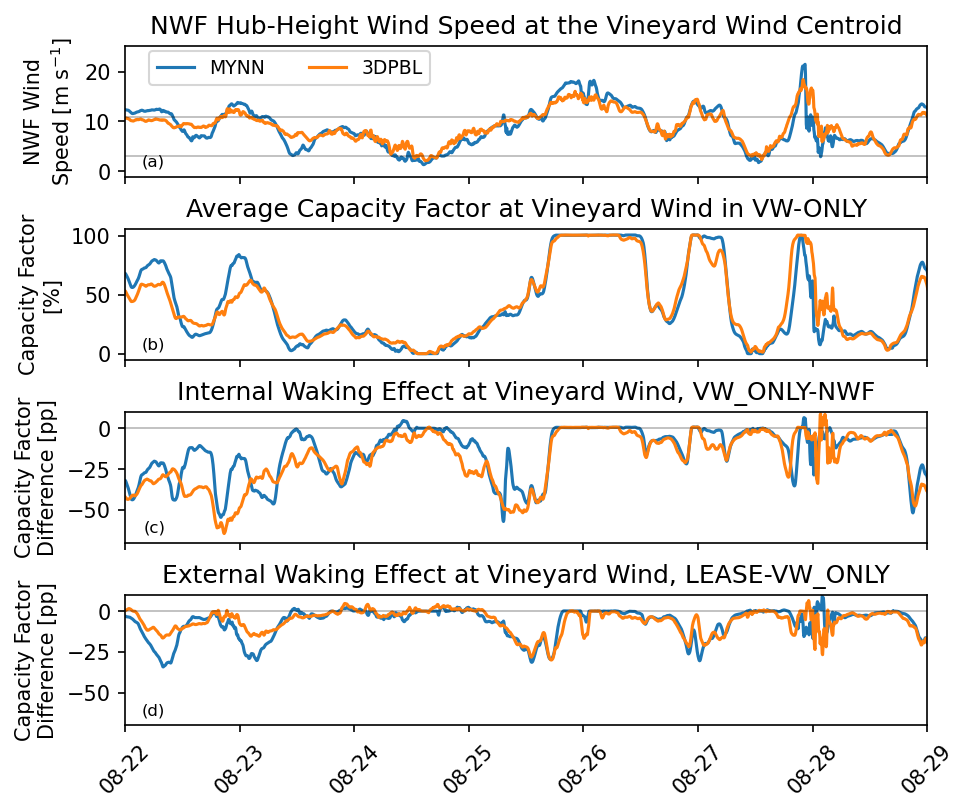

In [51]:
fig, ax = plt.subplots(4, 1, figsize=(6.9, 6), sharex=True, dpi=150)

## Plot data
ax[0].plot(times, wspd_m, label='MYNN', color='C0')
ax[0].plot(times, wspd_hv, label='3DPBL', color='C1')

ax[1].plot(times, capfac_v_m_smean, label='MYNN', color='C0')
ax[1].plot(times, capfac_v_hv_smean, label='3DPBL', color='C1')

ax[2].plot(times, capfac_v_m_smean-capfac_n_m_smean, label='MYNN', color='C0')
ax[2].plot(times, capfac_v_hv_smean-capfac_n_hv_smean, label='3DPBL', color='C1')

ax[3].plot(times, capfac_f_m_smean-capfac_v_m_smean, label='MYNN', color='C0')
ax[3].plot(times, capfac_f_hv_smean-capfac_v_hv_smean, label='3DPBL', color='C1')

## Decorate
ax[0].set_xlim(times[3*10080//5], times[4*10080//5])
ax[0].set_title("NWF Hub-Height Wind Speed at the Vineyard Wind Centroid")
ax[1].set_title("Average Capacity Factor at Vineyard Wind in VW-ONLY")
ax[2].set_title("Internal Waking Effect at Vineyard Wind, VW_ONLY-NWF")
ax[3].set_title("External Waking Effect at Vineyard Wind, LEASE-VW_ONLY")

ax[0].set_ylabel("NWF Wind\nSpeed [m s$^{-1}$]")
ax[1].set_ylabel("Capacity Factor\n[%]")
ax[2].set_ylabel("Capacity Factor\nDifference [pp]")
ax[3].set_ylabel("Capacity Factor\nDifference [pp]")

ax[0].axhline(3, color='k', alpha=0.3, lw=0.75)
ax[0].axhline(10.9, color='k', alpha=0.3, lw=0.75)
ax[2].axhline(0, color='k', alpha=0.3, lw=0.75)
ax[3].axhline(0, color='k', alpha=0.3, lw=0.75)

ax[2].set_ylim(-70, 10)
ax[3].set_ylim(-70, 10)
ax[2].set_yticks([0, -25, -50])
ax[3].set_yticks([0, -25, -50])

# ax[0].set_ylim(-80, 5)

plt.subplots_adjust(hspace=0.4)
myFmt = mdates.DateFormatter('%m-%d')
ax[-1].xaxis.set_major_formatter(myFmt)
ax[-1].xaxis.set_tick_params(rotation=45)

handles, labels = ax[0].get_legend_handles_labels()
lgd = ax[0].legend(handles, labels, bbox_to_anchor=(0.03, 0.86, 0.35, .102), loc='upper left', fontsize=9, ncol=2, mode='expand',borderaxespad=0.)

## Subpanel labels
for axs, letter in zip(ax.flatten(), list(string.ascii_lowercase)):
    axs.text(0.05,
          0.08,
          f'({letter})',
          fontsize=8,
          transform = axs.transAxes,
          horizontalalignment='right',
            color='black')

# plt.savefig(f'../figs/vw_power_timeseries.pdf', bbox_inches='tight')
# plt.savefig(f'../figs/vw_power_timeseries.png', bbox_inches='tight')
    
plt.show()

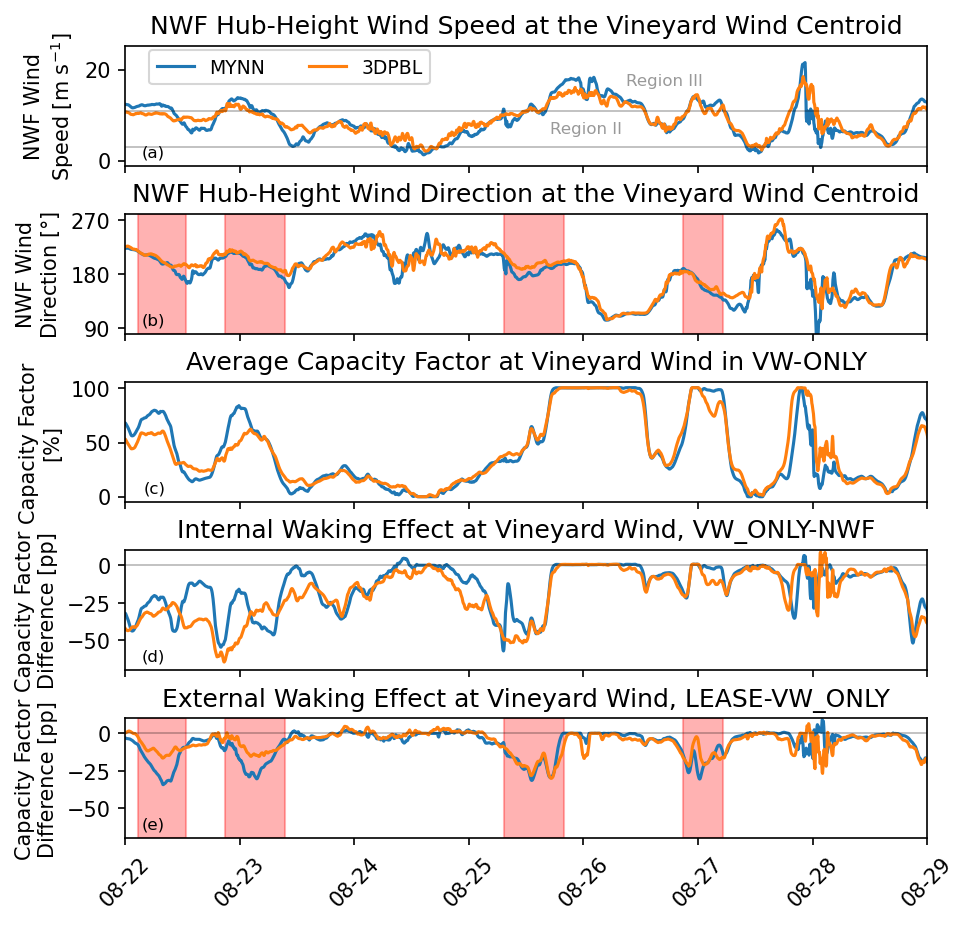

In [52]:
fig, ax = plt.subplots(5, 1, figsize=(6.9, 7), sharex=True, dpi=150)

## Plot data
ax[0].plot(times, wspd_m, label='MYNN', color='C0')
ax[0].plot(times, wspd_hv, label='3DPBL', color='C1')

ax[1].plot(times, wdir_m, label='MYNN', color='C0')
ax[1].plot(times, wdir_hv, label='3DPBL', color='C1')

ax[2].plot(times, capfac_v_m_smean, label='MYNN', color='C0')
ax[2].plot(times, capfac_v_hv_smean, label='3DPBL', color='C1')

ax[3].plot(times, capfac_v_m_smean-capfac_n_m_smean, label='MYNN', color='C0')
ax[3].plot(times, capfac_v_hv_smean-capfac_n_hv_smean, label='3DPBL', color='C1')

ax[4].plot(times, capfac_f_m_smean-capfac_v_m_smean, label='MYNN', color='C0')
ax[4].plot(times, capfac_f_hv_smean-capfac_v_hv_smean, label='3DPBL', color='C1')

## Decorate
ax[0].set_xlim(times[3*10080//5], times[4*10080//5])
ax[0].set_title("NWF Hub-Height Wind Speed at the Vineyard Wind Centroid")
ax[1].set_title("NWF Hub-Height Wind Direction at the Vineyard Wind Centroid")
ax[2].set_title("Average Capacity Factor at Vineyard Wind in VW-ONLY")
ax[3].set_title("Internal Waking Effect at Vineyard Wind, VW_ONLY-NWF")
ax[4].set_title("External Waking Effect at Vineyard Wind, LEASE-VW_ONLY")

ax[0].set_ylabel("NWF Wind\nSpeed [m s$^{-1}$]")
ax[1].set_ylabel("NWF Wind\nDirection [$\degree$]")
ax[2].set_ylabel("Capacity Factor\n[%]")
ax[3].set_ylabel("Capacity Factor\nDifference [pp]")
ax[4].set_ylabel("Capacity Factor\nDifference [pp]")

ax[0].axhline(3, color='k', alpha=0.3, lw=0.75)
ax[0].axhline(10.9, color='k', alpha=0.3, lw=0.75)
ax[3].axhline(0, color='k', alpha=0.3, lw=0.75)
ax[4].axhline(0, color='k', alpha=0.3, lw=0.75)

# ax[1].set_ylim(150, 225)
ax[1].set_ylim(80, 280)
ax[1].set_yticks([90, 180, 270])
ax[2].set_yticks([0, 50, 100])
ax[3].set_yticks([0, -25, -50])
ax[3].set_ylim(-70, 10)
ax[4].set_ylim(-70, 10)
ax[3].set_yticks([0, -25, -50])
ax[4].set_yticks([0, -25, -50])

# ax[0].set_ylim(-80, 5)

plt.subplots_adjust(hspace=0.4)
myFmt = mdates.DateFormatter('%m-%d')
ax[-1].xaxis.set_major_formatter(myFmt)
ax[-1].xaxis.set_tick_params(rotation=45)

handles, labels = ax[0].get_legend_handles_labels()
lgd = ax[0].legend(handles, labels, bbox_to_anchor=(0.03, 0.86, 0.35, .102), loc='upper left', fontsize=9, ncol=2, mode='expand',borderaxespad=0.)

## Subpanel labels
for axs, letter in zip(ax.flatten(), list(string.ascii_lowercase)):
    axs.text(0.05,
          0.08,
          f'({letter})',
          fontsize=8,
          transform = axs.transAxes,
          horizontalalignment='right',
            color='black')
    
ax[0].text(0.62,
      0.27,
      'Region II',
      fontsize=8,
      transform = ax[0].transAxes,
      horizontalalignment='right',
      color='black',
      alpha=0.4)

ax[0].text(0.72,
      0.67,
      'Region III',
      fontsize=8,
      transform = ax[0].transAxes,
      horizontalalignment='right',
      color='black',
      alpha=0.4)

for i in [1,4]:
    ax[i].axvspan(times[6080], times[6200], alpha=0.3, color='r')
    ax[i].axvspan(times[6300], times[6450], alpha=0.3, color='r')
    ax[i].axvspan(times[7000], times[7150], alpha=0.3, color='r')
    ax[i].axvspan(times[7450], times[7550], alpha=0.3, color='r')
    
# plt.savefig(f'../figs/vw_power_timeseries.pdf', bbox_inches='tight')
# plt.savefig(f'../figs/vw_power_timeseries.png', bbox_inches='tight')
    
plt.show()

External waking is strongest at 180-200 degrees